<a href="https://colab.research.google.com/github/mozzaquatro/financial_market/blob/main/Backtest_da_Estrat%C3%A9gia_de_M%C3%A1ximas_e_M%C3%ADnimas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No mercado financeiro existem diversas estratégias para estabelecer pontos de compra e venda a partir da análise técnica do gráfico de um ativo. Uma delas é a estratégia de máximas e mínimas, tema do post de hoje.

A estratégia de máximas e mínimas baseia-se em estabelecer o preço de compra na mínima dos dois dias anteriores e o preço de venda na máxima dos dois dias anteriores.

A imagem a seguir nos ajuda a visualizar melhor a estratégia. Repare que nós precisamos de pelo menos 3 candles, uma vez que o preço de compra e venda será estabelecido pela máxima dos dois candles anteriores. Além disso, é importante destacar que o ponto de venda será atualizado a cada dia, caso o preço estabelecido não seja atingido, como foi o caso do exemplo abaixo. 
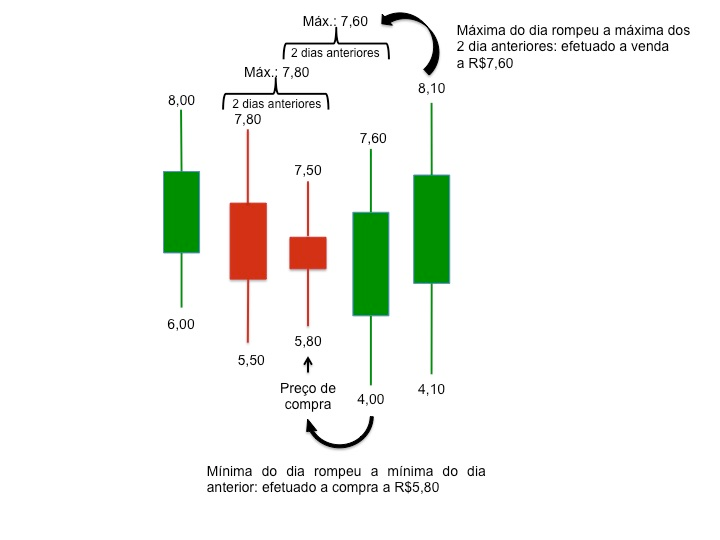

Esse post é o primeiro de uma série onde inicialmente escreveremos o algoritmo e, nos próximos, analisaremos outros cenários e faremos análises mais técnicas.

Vamos então para o passo a passo de como escrever um algoritmo em Python para a estratégia de máximas e mínimas.


**Importando as bibliotecas**

O primeiro passo é importar as bibliotecas que utilizaremos. Como será comum daqui pra frente, utilizaremos pandas para manipulação de dados e matplotlib para sua visualização. Por simplicidade utilizaremos o módulo do Yahoo Finance para coletarmos a base de dados.

In [1]:
# %%capture means we suppress the output
%%capture

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install yfinance 
import yfinance as yf

**Download da base de dados**

Em seguida iremos fazer o download de um ativo qualquer em um período arbitrário, selecionando apenas as colunas que serão utilizadas na estratégia.

In [2]:
ticker = 'USIM5.SA'
start = '2021-01-01'
end = '2021-08-19'
df = yf.download(ticker, start, end)[["Open", "High", "Low", "Close"]]
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2021-01-04,14.910000,15.440000,14.890000,14.940000
2021-01-05,14.970000,15.230000,14.560000,15.100000
2021-01-06,15.220000,16.150000,15.100000,15.830000
2021-01-07,15.910000,16.590000,15.910000,16.590000
2021-01-08,16.780001,17.080000,16.100000,16.510000
...,...,...,...,...
2021-08-11,22.200001,22.430000,22.000000,22.030001
2021-08-13,21.799999,21.959999,21.020000,21.150000
2021-08-16,20.870001,20.870001,20.000000,20.030001


**Definindo as máximas e mínimas**

Antes de criarmos a lógica que irá estabelecer os possíveis pontos de entrada e saída, nós temos primeiro que isolar as máximas e mínimas de interesse.

Para estabelecer o ponto de **saída** nós sempre olhamos as máximas dos dois dias anteriores. Portanto, iremos utilizar o método .shift() para separar, em duas colunas diferentes (Target1 e Target2), as máximas dos dois dias anteriores a cada linha. Em seguida, aplicando o método .max() sobre essas duas colunas, nós teremos nosso preço alvo (Target). 

In [3]:
df["Target1"] = df["High"].shift(1)
df["Target2"] = df["High"].shift(2)
df["Target"] = df[["Target1", "Target2"]].max(axis=1)

# We don't need them anymore
df.drop(columns=["Target1", "Target2"], inplace=True)

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Target
Date,,,,,
2021-01-04,14.910000,15.44,14.89,14.94,NaN
2021-01-05,14.970000,15.23,14.56,15.10,15.44
2021-01-06,15.220000,16.15,15.10,15.83,15.44
2021-01-07,15.910000,16.59,15.91,16.59,16.15
2021-01-08,16.780001,17.08,16.10,16.51,16.59


A lógica para para estabelecer o ponto de **entrada** é semelhante — a entrada será disparada na mínima dos dois dias anteriores.

In [4]:
df["Entry1"] = df["Low"].shift(1)
df["Entry2"] = df["Low"].shift(2)
df["Entry"] = df[["Entry1", "Entry2"]].min(axis=1)

# We don't need them anymore
df.drop(columns=["Entry1", "Entry2"], inplace=True)

df.head()

,Open,High,Low,Close,Target,Entry
Date,,,,,,
2021-01-04,14.910000,15.44,14.89,14.94,NaN,NaN
2021-01-05,14.970000,15.23,14.56,15.10,15.44,14.89
2021-01-06,15.220000,16.15,15.10,15.83,15.44,14.56
2021-01-07,15.910000,16.59,15.91,16.59,16.15,14.56
2021-01-08,16.780001,17.08,16.10,16.51,16.59,15.10


**Definindo as regras da operação**

Uma vez que os pontos de entrada e saída estão definidos, nós precisamos estabelecer quais foram os exatos pontos de compra e venda. Repare que não necessariamente eles são iguais, uma vez que o mercado pode abrir abaixo do seu ponto de entrada ou acima do seu ponto de saída. Dessa forma, tanto o ponto de entrada quanto saída devem ser entendidos como **gatilhos** para tomada de alguma decisão.

Sendo assim, vamos estabelecer algumas regras:

 - Caso o mercado abra abaixo do ponto de entrada (Entry), a compra será feita imediatamente no preço de abertura (Open);
 - Caso o mercado abra acima do ponto de saída (Target), a venda será feita imediatamente no preço de abertura (Open).

Nós temos agora todas as regras necessárias para, dado uma linha no dataframe, identificar os exatos pontos de compra (Buy Price) e venda (Sell Price), caso existam.

A lógica segue o seguinte raciocínio:

 1. Quando a mínima do dia atual for menor que o ponto de entrada (Low < Entry) e o preço de abertura for menor que o ponto de entrada (Open < Entry), o preço de compra (Buy Price) será igual ao preço de abertura (Open).
 2. Por outro lado, se o preço de abertura for maior que o ponto de entrada, mas a mínima do dia for menor que o ponto de entrada, a compra será feita no exato valor do ponto de entrada (Entry).
 3. Se nenhum dos eventos acima acontecerem, ou seja, se a mínima do dia atual não for menor que o ponto de entrada, nada será feito e Buy Price será preenchido como np.nan. A lógica é análoga para o preço de venda (Sell Price).

Utilizaremos a função np.where para implementar as condições acima — seu uso se dá por np.where(condition, x, y), onde, se condition for verdadeiro, retorna-se x, e caso falso, retorna-se y. 

In [5]:
# Define exact buy price
df['Buy Price'] = np.where(
    df["Low"] < df['Entry'],
    np.where((df['Open'] < df['Entry']), df['Open'], df['Entry']),
    np.nan)

# Define exact sell price
df['Sell Price'] = np.where(
    df["High"] > df['Target'], 
    np.where(df['Open'] > df['Target'], df['Open'], df['Target']),
    np.nan)

df.head(10)

,Open,High,Low,Close,Target,Entry,Buy Price,Sell Price
Date,,,,,,,,
2021-01-04,14.910000,15.440000,14.89,14.940000,NaN,NaN,NaN,NaN
2021-01-05,14.970000,15.230000,14.56,15.100000,15.440000,14.89,14.89,NaN
2021-01-06,15.220000,16.150000,15.10,15.830000,15.440000,14.56,NaN,15.440000
2021-01-07,15.910000,16.590000,15.91,16.590000,16.150000,14.56,NaN,16.150000
2021-01-08,16.780001,17.080000,16.10,16.510000,16.590000,15.10,NaN,16.780001
2021-01-11,16.309999,17.309999,16.10,16.709999,17.080000,15.91,NaN,17.080000
2021-01-13,16.440001,16.440001,15.41,15.480000,17.309999,16.10,16.10,NaN
2021-01-14,15.640000,15.870000,15.43,15.760000,17.309999,15.41,NaN,NaN
2021-01-15,15.540000,15.670000,14.81,15.020000,16.440001,15.41,15.41,NaN


**Criando o algoritmo para simular as operações**

Nosso dataframe agora contém todas as informações que nós precisamos. Mas ainda há trabalho a ser feito!

Um algoritmo nada mais é do que um conjunto de instruções performadas pelo computador. Sendo assim, nós precisamos instruir o computador a seguir exatamente os passos que um ser humano faria manualmente.

Dito isso, vamos estabelecer algumas regras para o nosso algoritmo:

 - Apenas uma operação pode estar em andamento por vez, ou seja, para que outra compra seja feita, o ativo tem que necessariamente ter atingido seu alvo inicial;
 - Operaremos apenas na ponta da compra. Isso significa que em nenhum momento ficaremos short (vendidos no papel a descoberto).

Dadas as regras acima, o primeiro passo é verificar se estamos no meio de uma operação ou não. Dessa forma, definiremos ongoing, uma variável de controle que nos autorizará a entrar em novas operações. Inicialmente ela será falsa, uma vez que não estamos com nenhuma operação em andamento.

Para simular as operações, nós temos que analisar cada linha das colunas onde separamos os possíveis preços de compra e venda (Buy Price e Sell Price). Portanto, iremos iterar sobre todo o dataframe — range(0, len(df)).

Caso haja uma operação em andamento, ou seja, se ongoing for True, nós temos que procurar por vendas. Nós já separamos todos os possíveis preços de venda na coluna Sell Price, então se encontrarmos qualquer valor numérico (~np.isnan), nós fechamos a operação naquele preço e ela se encerra (ongoing se torna False).

Agora, se nós não estivermos com uma operação em andamento, então temos que procurar por uma compra: se encontrarmos um valor numérico (~np.isnan) na nossa coluna Buy Price, nós compramos naquele valor e iniciamos uma operação (ongoing se torna true). 

In [6]:
# Define control variable for ongoing operations
ongoing = False

for i in range(0,len(df)):

    # If there is an ongoing operation, check if we reached the target price
    if ongoing == True:
        if ~(np.isnan(df['Sell Price'][i])):
            exit = df['Sell Price'][i]
            ongoing = False

    # If there is no ongoing operation, check if the entry price was achieved
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            ongoing = True


Agora que já definimos quando as operações começam e terminam, iremos calcular o resultado das operações.

Para esse backtest utilizaremos a seguinte estratégia: alocaremos uma quantidade inicial de capital e compraremos o máximo de lotes cheios (múltiplos de 100) que conseguirmos. Sendo assim, toda operação terá uma quantidade fixa de capital disponível. 

In [7]:
import math

# Create a function to round any number to the smalles multiple of 100
def round_down(x):
  return int(math.floor(x / 100.0)) * 100

print(round_down(220)) # Can buy at most 200 shares
print(round_down(255.67)) # Can buy at most 200 shares
print(round_down(300)) # Can buy exactly 300 shares

200
200
300


Para calcular o resultado da estratégia, criaremos duas listas: uma para o capital acumulado e outra para o resultado de cada operação. Faremos isso em forma de lista para podermos plotar a evolução do capital e fazer outras análises mais pra frente.

O profit então nada mais é do que a diferença do valor de venda da ação (exit) pelo valor de compra (entry), multiplicado pela quantidade de ações que nós compramos (shares), e esse valor é então adicionado ao capital até o momento. 

In [8]:
# Define backtest parameters
initial_capital = 10000

total_capital = [initial_capital] # list with the total capital after every operation
all_profits = [] # list with the results of every operation
ongoing = False 

for i in range(0,len(df)):
    if ongoing == True:

        if ~(np.isnan(df['Sell Price'][i])):

            # Define exit point and total profit
            exit = df['Sell Price'][i]
            profit = shares * (exit - entry)

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1] # current capital is the last entry in the list
            total_capital += [current_capital + profit]
            ongoing = False
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            shares = round_down(initial_capital / entry)
            ongoing = True

Com nosso algoritmo pronto, vamos analisar qual foi nossa porcentagem de acertos, erros e o lucro total. Iremos escrever o código em uma função, de forma a realizar a mesma análise mais tarde. 

In [9]:
def strategy_test(all_profits): 
  num_operations = len(all_profits)
  gains = sum(x >= 0 for x in all_profits)
  pct_gains = 100 * (gains / num_operations)
  losses = num_operations - gains
  pct_losses = 100 - pct_gains

  print("Number of operations =", num_operations)
  print("Number of gains =", gains, "or", pct_gains.round(), "%")
  print("Number of loss =", losses, "or", pct_losses.round(), "%")
  print("The total profit was =", sum(all_profits))

strategy_test(all_profits)

Number of operations = 16
Number of gains = 10 or 62.0 %
Number of loss = 6 or 38.0 %
The total profit was = 1023.9999771118164


Agora, vamos ver a evolução do nosso capital em um gráfico. Novamente escreveremos em forma de função, a fim de utilizar o mesmo código mais pra frente.

Uma pequena observação: para plotarmos o gráfico de results por total_capital, ambas as listas precisam ser do mesmo tamanho. Como a origem do gráfico é o ponto (0, initial_capital), vamos adicionar 0 no início da lista de resultados.

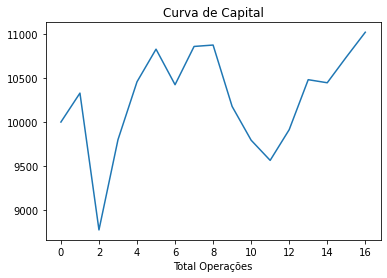

In [10]:
def capital_plot(total_capital, all_profits):
  all_profits = [0] + all_profits # make sure both lists are the same size
  cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
  plt.title("Curva de Capital")
  plt.xlabel("Total Operações")
  cap_evolution['Capital'].plot()

capital_plot(total_capital, all_profits)

**Calculando o tempo médio de operação**

Nossa estratégia teve impressionantes 79% de acerto, mas ela tem um ponto negativo: como não há stop no preço, existem situações onde ficamos muito tempo exposto a um mesmo trade. A pergunta natural então é: podemos adicionar um stop no tempo?

Vamos primeiro calcular quantos dias leva, em média, uma operação.

Para isso, criaremos três variáveis: days_in_operation, total_days e total_operations. Se estivermos em uma operação (ongoing é True), então incrementaremos days_in_operation, até atingirmos nosso ponto de venda.

Quando encerramos a operação, ongoing é False e somamos 1 à nossa variável total_operations. Finalmente, somamos days_in_operation com total_days. A média nada mais é do que o total_days / total_operations.

Por simplicidade, vamos manter no código apenas o necessário para o nosso estudo do tempo.

In [11]:
days_in_operation = 0
total_days = 0
total_operations = 0
ongoing = False

for i in range(0,len(df)):
    if ongoing == True:
        days_in_operation += 1
        if ~(np.isnan(df['Sell Price'][i])):
            ongoing = False

            # Operation has ended, increase total_operations value and sum how
            # many days the current operation took to complete
            total_operations += 1
            total_days += days_in_operation
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            ongoing = True

            # Operatio has started, initialize count of days until it ends
            days_in_operation = 0       

print("Average length of operations (in days)", total_days / total_operations)

Average length of operations (in days) 3.6875


De uma maneira geral, as operações levam, em média, 3 dias.

Agora vamos calcular quanto tempo levam, em média, as operações que dão lucro e as que dão prejuízo. Assim poderemos compará-las e estabelecer o nosso stop loss de acordo com a média de dias de uma operação que resultou em lucro.

A lógica é bem similar a que escrevemos acima:

In [12]:
days_in_operation = 0
gains_total_days = 0
gains_total_operations = 0
losses_total_days = 0
losses_total_operations = 0
ongoing = False

for i in range(0,len(df)):
    if ongoing == True:
        days_in_operation += 1
        if ~(np.isnan(df['Sell Price'][i])):
            exit = df['Sell Price'][i]
            is_positive = exit > entry
            ongoing = False
            
            # If profit is positive we increment the gains' variables
            # Else, we increment the losses' variables
            if is_positive > 0: 
                gains_total_days += days_in_operation
                gains_total_operations += 1
            else: 
                losses_total_days += days_in_operation
                losses_total_operations += 1
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            days_in_operation = 0
            ongoing = True

print("Average length of gains (in days)", gains_total_days / gains_total_operations)
print("Average length of losses (in days)", losses_total_days / losses_total_operations)

Average length of gains (in days) 1.5
Average length of losses (in days) 7.333333333333333


Como podemos observar, as operações que dão lucro levam, na média, entre 2 e 3 dias, enquanto as que dão prejuízo levam mais que o dobro do tempo. Vamos então estabelecer um limite de 3 dias e nos proteger de operações muito longas. 

**Adicionando um stop no tempo**

Para limitar nossas operações a nnn dias, nós temos apenas que adicionar uma condição a nossa lógica: se estivermos no nnn-ésimo dia de operação (days_in_operation == max_days), iremos vender a ação naquele dia pelo preço de fechamento (exit = df['Close'][i]).

Finalmente, vamos juntar tudo que escrevemos até aqui e finalizar nosso algoritmo.

In [13]:
# Define backtest parameters
initial_capital = 10000
max_days = 3 # add stop in time

# Control variables
total_capital = [initial_capital] # list with the total capital after every operation
all_profits = [] # list with profits for every operation
days_in_operation = 0
gains_total_days = 0
gains_total_operations = 0
losses_total_days = 0
losses_total_operations = 0
ongoing = False 

for i in range(0,len(df)):
    if ongoing == True:
        days_in_operation += 1

        # If any of the following conditions are met, the operation will end
        if days_in_operation == max_days or ~(np.isnan(df['Sell Price'][i])):

            # Define exit point and total profit
            exit = np.where(
                ~(np.isnan(df['Sell Price'][i])), 
                df['Sell Price'][i], 
                df['Close'][i])
            profit = shares * (exit - entry)

            # Append profit to list and create a new entry with the capital
            # after the operation is complete
            all_profits += [profit]
            current_capital = total_capital[-1]
            total_capital += [current_capital + profit]

            # If profit is positive we increment the gains' variables
            # Else, we increment the losses' variables
            if profit > 0:
                gains_total_days += days_in_operation
                gains_total_operations += 1
            else: 
                losses_total_days += days_in_operation
                losses_total_operations += 1
            
            ongoing = False
    else:
        if ~(np.isnan(df['Buy Price'][i])):
            entry = df['Buy Price'][i]
            shares = round_down(initial_capital / entry)
            days_in_operation = 0
            ongoing = True

# Define total number of days and the total number of operations during the period
total_days = gains_total_days + losses_total_days
total_operations = gains_total_operations + losses_total_operations

print("Average length of operations (in days)", total_days / total_operations)
print("Average length of gains (in days)", gains_total_days / gains_total_operations)
print("Average length of losses (in days)", losses_total_days / losses_total_operations)


Average length of operations (in days) 2.25
Average length of gains (in days) 1.6153846153846154
Average length of losses (in days) 3.0


Por fim, vamos calcular as estatísticas da estratégia e plotar a evolução do nosso capital.

In [14]:
strategy_test(all_profits)

Number of operations = 24
Number of gains = 13 or 54.0 %
Number of loss = 11 or 46.0 %
The total profit was = 759.9987030029297


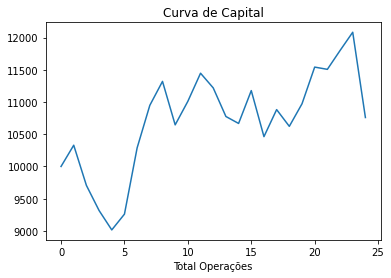

In [15]:
capital_plot(total_capital, all_profits)

Algumas considerações sobre a adição do stop no tempo:

 - Em termos de lucro e taxa de acerto, limitar o tempo de cada operação diminuiu o nosso ganho. Isso é esperado uma vez que nós estamos encerrando nossas operações logo no terceiro dia;
 - Também por diminuirmos o tempo médio das operações (de 3.24 para 2.35 dias), aumentamos o número de operações (204 x 237);
 - Entretando, a expectativa é que o drawdown da estratégia seja menor.

Não sabe o que é drawdown? Gostaria de ver essa estratégia em outros ativos do índice Bovespa ou até mesmo em diferentes períodos operacionais? Fique ligado nos próximos posts dessa série e se inscreva abaixo na nossa newsletter para não perder nenhuma novidade!